<a href="https://colab.research.google.com/github/gapself/machine-learning/blob/main/natural-language-processing-projects/covid_twitter_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid Tweets Preprocessing

In [ ]:
!python -m pip install spacy==2.3.2 -q
!python -m spacy download pl_core_news_md  -q

     |████████████████████████████████| 79.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')


In [ ]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
import time
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import re
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from wordcloud import WordCloud
import multiprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pobranie tweetów z twittera

## plik txt załączony - nie ma potrzeby ponownego uruchamoania

In [ ]:
api_key = 'XX'
api_key_secret = 'XX'
access_token = 'XX'
access_token_secret = 'XX'

In [ ]:
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
f =  open('/content/drive/MyDrive/Twitter/pl_covid_tweets_clean.txt') 
f1 =f.readlines()

In [ ]:
df = pd.DataFrame(f1)
df = df[0].str.split(expand=True,)
df = df[0][1:]
df = pd.DataFrame(df)
df.columns = ['tweet_id']

In [ ]:
tweet_txt = []
sec = 0 
a = 0
b = 100
while sec < round(len(df)/100):
  try:
    tweets = api.statuses_lookup(list(df['tweet_id'][a:b]))
    for i in tweets:
      tweet_txt.append(i.text)
   
    if (sec % 100) == 0:
      with open('/content/drive/MyDrive/Twitter/pl_covid_tweets.txt', 'w') as f:
        for item in tweet_txt:
          item = item.replace('\n', ' ')
          f.write("%s\n" % item)
      print("sequence number:", sec)
    sec+=1
    a = 100 * sec
    b = 100 + 100 * sec

  except BaseException as e:
          print('failed on_status,',str(e)) 
          time.sleep(5) 

####Wczytanie tweetów z pliku tekstowego

In [ ]:
raw_tweets = pd.read_csv(f'/content/drive/MyDrive/Twitter/pl_covid_tweets.txt', sep='delimiter', header = None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
raw_tweets.columns = ['tweet']
raw_tweets

,tweet
0,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,A tymczasem w Wuhan odcięto od reszty świata o...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."
...,...
483655,Adi w natarciu 😁 https://t.co/CXdSR1AST2
483656,Kwarantanna osób zaszczepionych nie jest potrz...
483657,pkp 4.0 ready sik? https://t.co/fHzdNsd3AL
483658,"@rafalhubert Alfabet, jak będzie trzeba, to si..."


## Czyszczenie i obróbka danych

In [ ]:
nlp = spacy.load('pl_core_news_md')
lemma = WordNetLemmatizer()
nltk.download('wordnet')
stopwordlist = nlp.Defaults.stop_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
raw_tweets['tweet'].drop_duplicates(keep="first", inplace=True)

In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    text = re.sub('[^a-zA-Z\']', ' ', text)
    text = re.sub('\t', '', text)
    text = re.sub('\S*@\S*\s?', ' ',text)
    text = emoji_pattern.sub(r'', text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist])
    text = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist]
    return text 

In [ ]:
raw_tweets['clean_text'] = raw_tweets['tweet'].apply(clean_text)
raw_tweets.dropna(subset = ["clean_text"], inplace=True)
raw_tweets['cleaned_text'] = raw_tweets['clean_text'].apply(lambda x:' '.join(x))


## **Labeling**

2 klasy - pozytywna i negatywna


In [ ]:
sent = [row for row in raw_tweets['clean_text']]
phrases = Phrases(sent, min_count=1, progress_per=500000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(sentences, progress_per= 500000)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(45852883, 98996850)

In [ ]:
w2v_model.save("/content/drive/MyDrive/Twitter/word2vec.model")

In [ ]:
word_vectors = Word2Vec.load("/content/drive/MyDrive/Twitter/word2vec.model").wv

In [ ]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[0]

In [ ]:
words = pd.DataFrame(word_vectors.index2entity)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [ ]:
words['cluster_value'] = [1 if i==1 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [ ]:
words[words["cluster_value"]==1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
5413,stanu_wyj,"[-0.098631576, -0.6654961, 1.3304988, 0.156235...",1,1,0.073572
4314,owej,"[0.0061311508, 0.6796716, 0.9942139, -0.026016...",1,1,0.073862
2968,lekarzy_piel,"[-0.2251644, 0.068139985, 0.011834906, -1.3252...",1,1,0.075686
5271,kszo,"[-0.30604944, -0.5789292, 0.63667375, -0.32025...",1,1,0.076180
2340,stan_wyj,"[-0.022780143, 0.3366357, 0.39410332, 0.907120...",1,1,0.078523
...,...,...,...,...,...
79819,bieniu_grypie,"[-0.03682679, 0.073585436, 0.06946283, -0.0510...",1,1,2.365201
76977,linie_wolfsburg,"[-0.049890462, 0.07741166, 0.03779513, -0.0552...",1,1,2.432541
72766,wytypowane_szpitale,"[-0.034950845, 0.0974787, -0.018025562, -0.068...",1,1,2.635330
63620,stworzy_bomb,"[-0.039301082, 0.0990868, 0.03439434, -0.03102...",1,1,3.073026


In [ ]:
words[words["cluster_value"]==0].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
3564,eczno_ciowych,"[0.84157884, -0.9855663, -0.07769974, 0.287853...",0,0,0.069289
3625,mediach_spo,"[0.39610904, -0.20883602, 0.38044462, -0.79207...",0,0,0.072002
4541,eczny,"[0.667587, -0.40313917, 0.17168981, 0.05372841...",0,0,0.073371
4483,dystans_spo,"[1.254755, 0.025978431, 0.69338137, 0.6226792,...",0,0,0.073612
3766,dek,"[-0.2526872, -0.18568578, -0.17977388, 0.55465...",0,0,0.081398
...,...,...,...,...,...
82156,posle,"[-0.054914992, 0.0025621697, 0.0020873982, -0....",0,0,3.021695
81606,zajumali,"[-0.061100382, -0.0041599036, 0.028920708, -0....",0,0,3.062114
79867,idiotycznymi,"[-0.028920334, 0.037153017, -0.001076283, -0.0...",0,0,3.099884
78264,berety,"[-0.04105159, 0.027003486, 0.009557617, -0.048...",0,0,3.106128


In [ ]:
positive = ['dobry','miły','niesamowity','śmieszny','kochany','słodki']
negative= ['głupi','szalony','niesympatyczny','zły','straszny', 'absurdalny' 'durny']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"] = 0

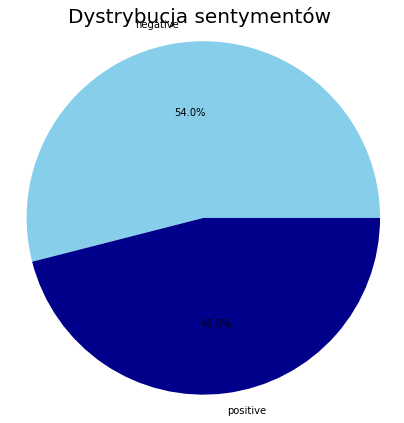

,index,sentiments
0,negative,45759
1,positive,39002


In [ ]:
emotion = {1: "positive",
           0: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["skyblue","darkblue"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [ ]:
from math import nan
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["clean_text"]
    for t in test:
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1 
    if count == 0:
     avg = 0 
    else:
      avg = total/count

    #print(avg)
    sentiment = 0 if avg < 0.5 else 1
    return sentiment

In [ ]:
words_dict = dict(zip(words.words, words.cluster_value))

In [ ]:
raw_tweets["sentiment"] = raw_tweets.apply(get_sentiments, args=(words_dict,), axis=1)

In [ ]:
raw_tweets["sentiment"].value_counts()

0    307530
1    176130
Name: sentiment, dtype: int64

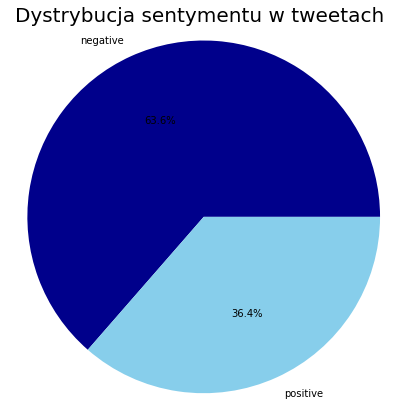

,index,sentiments_val
0,negative,307530
1,positive,176130


In [ ]:
emotion = {1: "positive",
           0: "negative"}

raw_tweets["sentiments_val"] = raw_tweets["sentiment"].map(emotion)
df_pie = raw_tweets["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["darkblue","skyblue"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
df_pie

In [ ]:
raw_tweets.head()

,tweet,clean_text,cleaned_text,sentiment,sentiments_val
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","[coronavirus, dotrze, polski, napotka, op, zna...",coronavirus dotrze polski napotka op znakomici...,0,negative
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"[kolejni, polacy, chc, wr, wuhan]",kolejni polacy chc wr wuhan,0,negative
2,A tymczasem w Wuhan odcięto od reszty świata o...,"[tymczasem, wuhan, odci, reszty, wiata, obszar...",tymczasem wuhan odci reszty wiata obszar por w...,0,negative
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"[zdziwi, si, powiedz, listy, pojecha, chin, wu...",zdziwi si powiedz listy pojecha chin wuhan odw...,0,negative
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","[rp, polak, wr, wuhan, ambasadzie, rp, pekinie...",rp polak wr wuhan ambasadzie rp pekinie powo a...,0,negative


In [ ]:
raw_tweets.to_csv( "/content/drive/MyDrive/Twitter/clean_tweets.csv", index=False, encoding='utf-8-sig')